In [1]:
%matplotlib inline

# Import Python packages

In [2]:
import copy, math, sys

from datetime import datetime

import requests

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator # Helpers to format and locate ticks for dates
plt.rc('font', size=12)

import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

from heatmap import heatmap, corrplot

import numpy as np

import pandas as pd # Load  CSV files

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from tslearn.clustering import KShape

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display


NoneType = type(None)

/home/fpvidal/miniconda3/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Define some functions

In [3]:
def plotCurves(df, col, ax, HBName, normalise=False):
    for HB in df[HBName].unique():
        test = df[HBName] == HB

        X = df[test]["Date"]
        Y = copy.deepcopy(df[test][col])

        # Use zero-mean, unit-variance normalisation (also called standardisation)
        if normalise:
            Y = TimeSeriesScalerMeanVariance().fit_transform([Y])[0]

        # Specify how our lines should look
        ax.plot( X, Y, label=HB)

    # Same as above
    ax.set_xlabel('Time')
    ax.set_ylabel(col)

    ax.grid(True)

    # Set the x-axis to do major ticks on the days and label them like '07/20'
    # ax.xaxis.set_major_locator(DayLocator())

    ax.xaxis.set_major_formatter(DateFormatter('%m/%Y'))
    ax.set_title(col)

In [4]:
# From https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=11,window='hanning') -> np.array:
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    # print(x.ndim, x.size, window_len)

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        return x
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
#     return y[(window_len // 2-1):-(window_len // 2+1)]
    return y

In [5]:
def correlateTimeSeries(series1, series2) -> np.array:
    """ Compute the cross-correlation between two 1-D signals (e.g. time series).

    It quantifies the level of similarity between two series as a function of the displacement of one relative to the other.
    If the inputs are both normalised, the cross correlation values are in the [-1, 1] range.
    -1 corresponds to a strong anticorrelation, or inverse correlation,;
    0 corresponds to a non-correlation; and
    1 corresponds to a strong correlation.

    Returns the np.array that contains the cross correlation.
    """

    if not series1 or not series2:
        raise ValueError('Correlation cannot be computed if any input is empty');

    # Use numpy to compute the cross correlation
    cross_corr = np.correlate(np.array(series1, dtype=np.float32), np.array(series2, dtype=np.float32), "same");
    return cross_corr / len(series1);

    # Use numpy to compute the cross correlation
    # return scipy.correlate(np.array(series1), np.array(series2), mode='same');


In [6]:
def getTimeSeries(df: pd.DataFrame,
                  HBName1: str, HBName2: str, 
                  col1: str, col2: str, 
                  window: str) -> pd.DataFrame:
    
    """ Create a new DataFrame. The first column is the date, the sencond is a count of the selected column of df, and the 3rd identifies the corresponding. If required, the data is smoothed using a filter (window).

    Return the time series as a Pandas DataFrame
    """

    # Create the column headers of the DataFrame
    columns = ["Date", "Normalised count", "data"];
    rows = []

    # Select the rows for the selected HB
    test_HB1 = df["HBName"] == HBName1
    test_HB2 = df["HBName"] == HBName2
    
    # Create the rows
    X1 = df[test_HB1][col1]
    X2 = df[test_HB2][col2]

    # Filter the data if necessary
    if not isinstance(window, NoneType):
        X1 = smooth(x=np.array(X1), window_len=5, window=window);
        X2 = smooth(x=np.array(X2), window_len=5, window=window);
            
    X1 = TimeSeriesScalerMeanVariance().fit_transform([X1])[0]
    X2 = TimeSeriesScalerMeanVariance().fit_transform([X2])[0]
    
    for date, x in zip(df[test_HB1]["Date"], X1):
        rows.append([date, x, HBName1 + "/" + col1])

    for date, x in zip(df[test_HB2]["Date"], X2):
        rows.append([date, x, HBName2 + "/" + col2])

    # Create the DataFrame
    output_df = pd.DataFrame(data=rows, columns=columns)

    return output_df;

In [7]:
def getCorrelation(df):

    corr = [];
    x_val = [];
    dates = [];
    lag = 0;

    if len(df["data"].unique()) == 2:
        
        field1 = df["data"].unique()[0];
        field2 = df["data"].unique()[1];

        dates = [];
        series1 = [];
        series2 = [];

        for date in df["Date"].unique():

            test1 = df["Date"] == date;
            
            if len(df[test1]["Date"]) == 2:

                test2 = df["data"] == field1
                test3 = df["data"] == field2
                
                dates.append(date);
                series1.append(df[test1 & test2]["Normalised count"].values[0][0]);
                series2.append(df[test1 & test3]["Normalised count"].values[0][0]);

                
                
                
        if len(dates) % 2 == 0:
            x_val = range(-math.floor(len(dates)/2), math.floor(len(dates)/2), 1);
        else:
            x_val = range(-math.floor(len(dates)/2), math.floor(len(dates)/2) + 1, 1);
      
        corr = correlateTimeSeries(series1, series2);
#         corr = smooth(x=np.array(corr), window_len=5, window="hamming");
        
        lag = x_val[np.argmax(corr, axis=0)];

    return corr, x_val, lag, dates;

In [8]:
def summarise(HBName1, HBName2, lag, corr):
    if lag == 0:
        print(HBName1, "and", HBName2, "are perfectly synchronysed in terms of DailyPositive")
    elif lag < 0:
        if lag == -1:
            print(HBName1, "is behind", HBName2, "by", lag, "day")
        else:
            print(HBName1, "is behind", HBName2, "by", lag, "days")
    else:
        if lag == 1:
            print(HBName1, "is ahead of", HBName2, "by", lag, "day")
        else:
            print(HBName1, "is ahead of", HBName2, "by", lag, "days")    

    print("Correlation:", "{:.2f}".format(np.max(corr) * 100) + "%")

In [9]:
def plotTimeLag(x_val, corr):

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot( x_val, corr)

    # Same as above
    ax.set_xlabel('Time lag')
    ax.set_ylabel('Correlation')

    ax.grid(True)

In [10]:
def plotWithoutAndWithTimeLag(df, lag, HBNames, cols):
    fig, ax_without_lag = plt.subplots(figsize=(10, 6))
    fig, ax_with_lag = plt.subplots(figsize=(10, 6))

    for i, (HBName, col) in enumerate(zip(HBNames, cols)):

        test = df["HBName"] == HBName

        X = df[test]["Date"]        
        Y = df[test][col]
        Y = TimeSeriesScalerMeanVariance().fit_transform([Y])[0]

        ax_without_lag.plot( X, Y, label=HBName)

        if i != 0:
            X += pd.DateOffset(lag)
        ax_with_lag.plot( X, Y, label=HBName + " (corrected)")

    # Same as above
    ax_without_lag.set_xlabel('Time')
    ax_with_lag.set_xlabel('Time')

    ax_without_lag.set_ylabel('DailyPositive')
    ax_with_lag.set_ylabel('DailyPositive')

    ax_without_lag.grid(True)
    ax_with_lag.grid(True)

    # Set the x-axis to do major ticks on the days and label them like '07/20'
    # ax_without_lag.xaxis.set_major_locator(DayLocator())
    # ax_with_lag.xaxis.set_major_locator(DayLocator())

    ax_without_lag.xaxis.set_major_formatter(DateFormatter('%m/%Y'))
    ax_with_lag.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

    ax_without_lag.legend(loc='lower left', bbox_to_anchor=(0.5, -0.4))
    # ax_with_lag.legend(loc='lower left')

    ax_without_lag.set_title("Standardised data for the first wave only\n" + HBNames[0] + " vs. " + HBNames[1])
    ax_with_lag.set_title("Standardised data for the first wave only\n" + HBNames[0] + " vs. " + HBNames[1] + "\nTaking into account the time lag")

In [11]:
def plotClusters(y_pred, df):
    
    for unique_cluster_id in np.unique(y_pred):
        fig, ax = plt.subplots(figsize=(10, 6))

        number_of_HBs = 0
        
        for HBName, cluster_id in zip(df["HBName"].unique(),y_pred):

            if cluster_id == unique_cluster_id:
                test = df["HBName"] == HBName

                X = df[test]["Date"]

                Y = df[test]["DailyPositive"]
                Y = TimeSeriesScalerMeanVariance().fit_transform([Y])[0]

                ax.plot(X, Y, label=HBName)
                
                number_of_HBs += 1

        ax.set_xlabel('Time')
        ax.set_ylabel('DailyPositive')

        ax.grid(True)

        ax.xaxis.set_major_formatter(DateFormatter('%m/%Y'))
        
        if number_of_HBs <= 4:
            ax.legend(loc='best')
        else:
            y = number_of_HBs / 12
            ax.legend(loc='lower left', bbox_to_anchor=(0.5, -y))

# Where is the data from?

See "Daily Case Trends By Health BoardCSV" in https://www.opendata.nhs.scot/dataset/covid-19-in-scotland

In [12]:
today = datetime.now()

day = str(today.day).zfill(2)
month = str(today.month).zfill(2)
year = today.year

print('Day: ', day) # To Get month from date
print('Month: ', month) # To Get month from date
print('Year: ', year) # To Get month from year

Day:  01
Month:  09
Year:  2021


In [13]:
fname = "trend_hb_" + str(year) + month + day + ".csv"
url = 'https://www.opendata.nhs.scot/dataset/b318bddf-a4dc-4262-971f-0ba329e09b87/resource/2dd8534b-0a6f-4744-9253-9565d62f96c2/download/' + fname
r = requests.get(url, allow_redirects=True)
# open(fname, 'wb').write(r.content)

# Load time series for NHS trusts in Scotland

In [14]:
# Load the file as a DataFrame
df = pd.read_csv(url)
            
# Remove rows for Scotland
df = df[df['HBName'] != 'Scotland']

# Convert the 'Date' cell to the Pandas datetime data type
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Save the DataFrame in a CSV file
# df.to_csv("temp.csv", index=False)

# Plot the daily number of positive tests and deaths

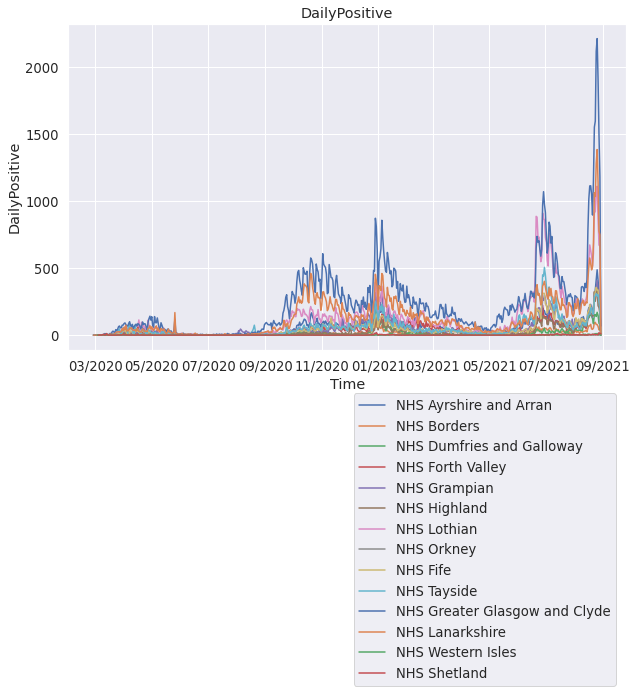

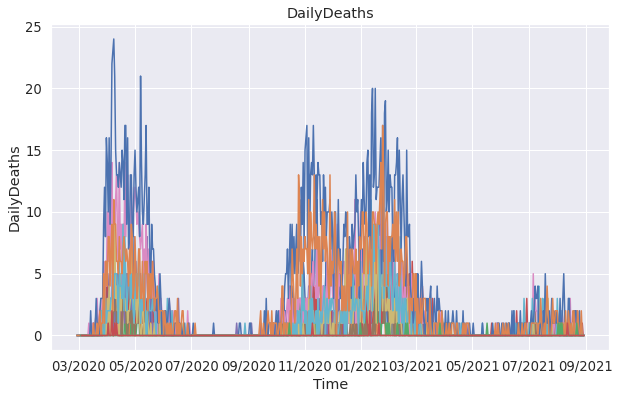

In [15]:
fig, ax_DailyPositive = plt.subplots(figsize=(10, 6))
fig, ax_DailyDeaths = plt.subplots(figsize=(10, 6))

plotCurves(df, "DailyPositive", ax_DailyPositive, "HBName")
ax_DailyPositive.legend(loc='lower left', bbox_to_anchor=(0.5, -1.05))

plotCurves(df, "DailyDeaths", ax_DailyDeaths, "HBName")

# Use zero-mean, unit-variance normalisation (also called standardisation) to compare the actual data

Text(0.5, 1.0, 'Standardised daily deaths')

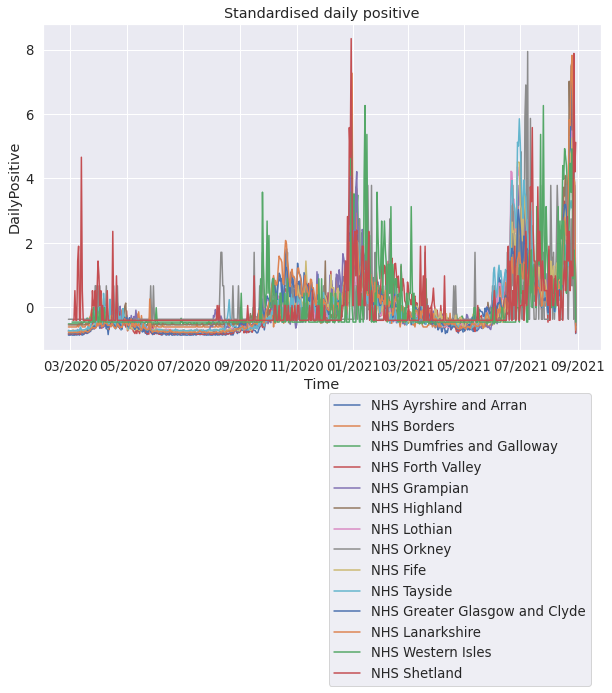

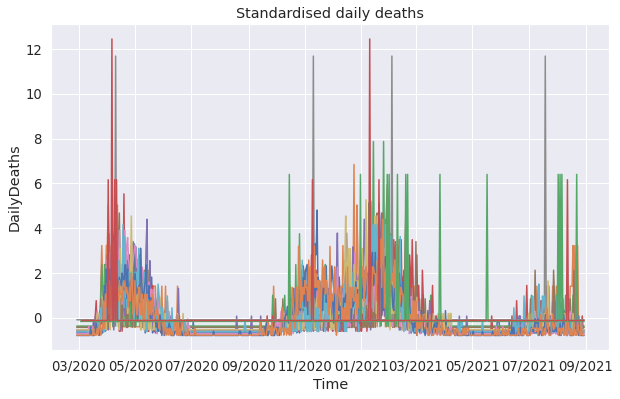

In [16]:
fig, ax_DailyPositive = plt.subplots(figsize=(10, 6))
fig, ax_DailyDeaths = plt.subplots(figsize=(10, 6))

plotCurves(df, "DailyPositive", ax_DailyPositive, "HBName", True)
ax_DailyPositive.legend(loc='lower left', bbox_to_anchor=(0.5, -1.05))
ax_DailyPositive.set_title("Standardised daily positive")

plotCurves(df, "DailyDeaths", ax_DailyDeaths, "HBName", True)
ax_DailyDeaths.set_title("Standardised daily deaths")

# First wave

Only consider the first wave. The "national intervention began on 23 March 2020 and restrictions were gradually lifted between 13 May and 4 July 2020." (source: https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/conditionsanddiseases/articles/coronaviruscovid19infectionsurveytechnicalarticle/wavesandlagsofcovid19inenglandjune2021)

In [17]:
end_date = '2020-7-4'
mask = df['Date'] <= end_date
df = df[mask]

Text(0.5, 1.0, 'Standardised daily deaths')

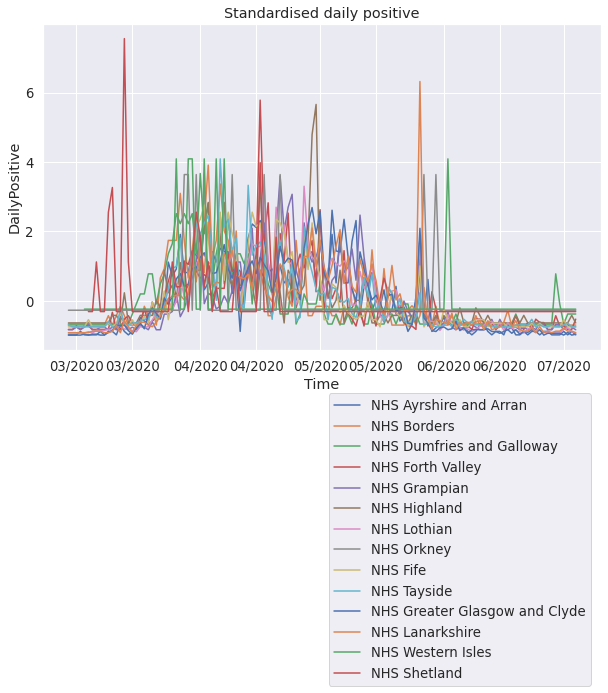

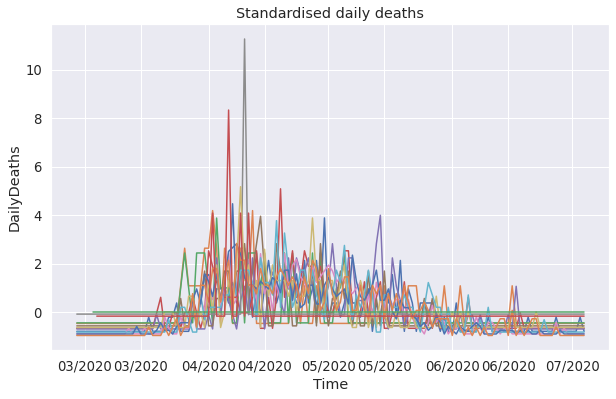

In [18]:
fig, ax_DailyPositive = plt.subplots(figsize=(10, 6))
fig, ax_DailyDeaths = plt.subplots(figsize=(10, 6))

plotCurves(df, "DailyPositive", ax_DailyPositive, "HBName", True)
ax_DailyPositive.legend(loc='lower left', bbox_to_anchor=(0.5, -1.05))
ax_DailyPositive.set_title("Standardised daily positive")

plotCurves(df, "DailyDeaths", ax_DailyDeaths, "HBName", True)
ax_DailyDeaths.set_title("Standardised daily deaths")

# An example: Daily positive cases for NHS Ayrshire and Arran, and NHS Fife

In [19]:
HBName1 = "NHS Ayrshire and Arran"
HBName2 = "NHS Fife"

In [20]:
temp_df = getTimeSeries(df, HBName1, HBName2, "DailyPositive", "DailyPositive", "hamming")

In [21]:
corr, x_val, lag, dates = getCorrelation(temp_df)

In [22]:
summarise(HBName1, HBName2, lag, corr)

NHS Ayrshire and Arran and NHS Fife are perfectly synchronysed in terms of DailyPositive
Correlation: 81.08%


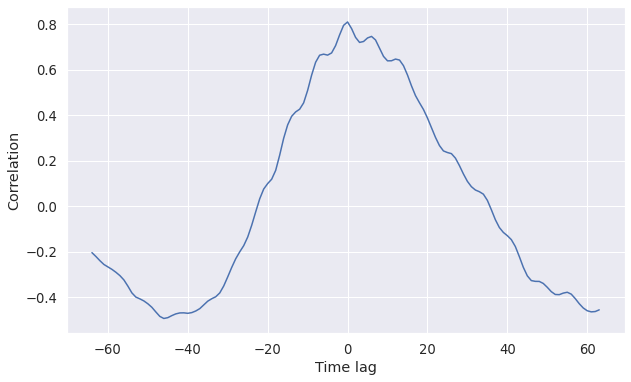

In [23]:
plotTimeLag(x_val, corr)

Text(0.5, 1.0, 'Standardised daily positive for the first wave only\nNHS Ayrshire and Arran vs. NHS Fife')

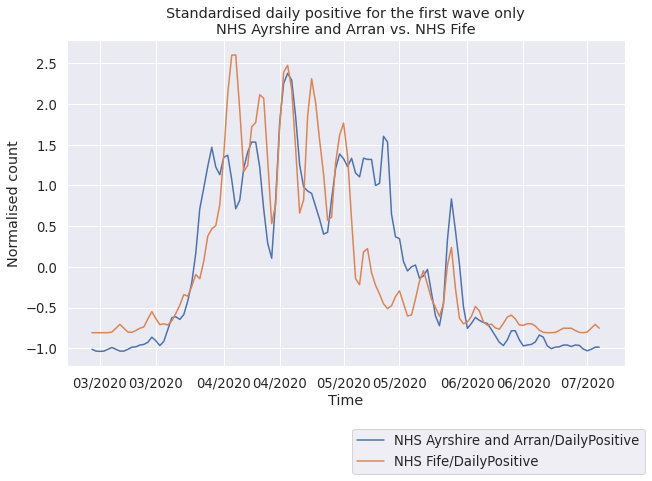

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
plotCurves(temp_df, "Normalised count", ax, "data")
ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.35))
ax.set_title("Standardised daily positive for the first wave only\n" + HBName1 + " vs. " + HBName2)

# Correlation matrices of DailyPositive and DailyPositive (with and without timelag correction)

In [25]:
max_lag = -sys.maxsize
max_improvement = 0.0

correlation_matrix_without_timelag = []
correlation_matrix_with_timelag = []

col1 = "DailyPositive"
col2 = "DailyPositive"

cols= []

df.to_csv("TEMP.CSV")
for HBName1 in df["HBName"].unique():
    
    cols.append(HBName1)

    row_without_timelag = []
    row_with_timelag = []

    for HBName2 in df["HBName"].unique():
        temp_df = getTimeSeries(df, HBName1, HBName2, col1, col2, "hamming")
        corr, x_val, lag, dates = getCorrelation(temp_df)
        
        if len(corr) == 0 and HBName1 == HBName2:
            row_without_timelag.append(1.0)
            row_with_timelag.append(1.0)
        else:
            row_without_timelag.append(corr[len(x_val) // 2])
            row_with_timelag.append(corr.max())
            
            test1 = df["HBName"] == HBName1
            test2 = df["HBName"] == HBName2
            
            if df[test1][col1].sum() > 150 and df[test2][col2].sum() > 150:

                if corr.max() > 0.8:
                    if max_lag < abs(lag):
                        max_lag = abs(lag)
                        max_lag_HBName1 = HBName1
                        max_lag_HBName2 = HBName2
                    
                improvement = abs(row_without_timelag[-1] - row_with_timelag[-1])
                if max_improvement < improvement:
                    max_improvement = improvement
                    max_improvement_HBName1 = HBName1
                    max_improvement_HBName2 = HBName2
                    correlation_before = row_without_timelag[-1]
                    correlation_after = row_with_timelag[-1]

    correlation_matrix_without_timelag.append(row_without_timelag)
    correlation_matrix_with_timelag.append(row_with_timelag)

In [26]:
print("Look for the row", max_improvement_HBName1, "in two matrices below")
print("Look for the column", max_improvement_HBName2, "in two matrices below")
print("Before lag correction, the correlation was", "{:.2f}".format(correlation_before * 100) + "%", "after it is", "{:.2f}".format(correlation_after * 100) + "%")

Look for the row NHS Dumfries and Galloway in two matrices below
Look for the column NHS Grampian in two matrices below
Before lag correction, the correlation was 32.89% after it is 78.73%


In [27]:
print("Look for the row", max_lag_HBName1, "in two matrices below")
print("Look for the column", max_lag_HBName2, "in two matrices below")

Look for the row NHS Grampian in two matrices below
Look for the column NHS Tayside in two matrices below


In [28]:
df_correlation_matrix_without_timelag = pd.DataFrame(data=correlation_matrix_without_timelag, columns=cols, index=cols)
df_correlation_matrix_with_timelag = pd.DataFrame(data=correlation_matrix_with_timelag, columns=cols, index=cols)

## Correlation matrices of DailyPositive and DailyPositive (without timelag correction)

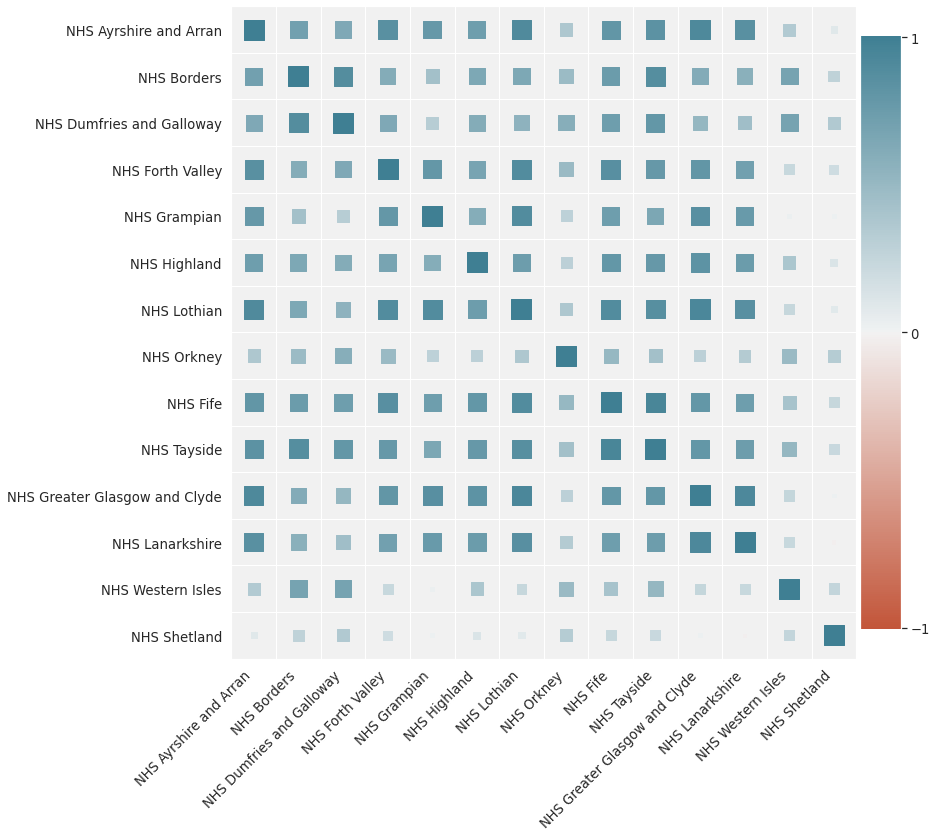

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Correlation matrix of " + col1 + " and " + col2)
corrplot(df_correlation_matrix_without_timelag, size_scale=400);

## Correlation matrices of DailyPositive and DailyPositive (with timelag correction)

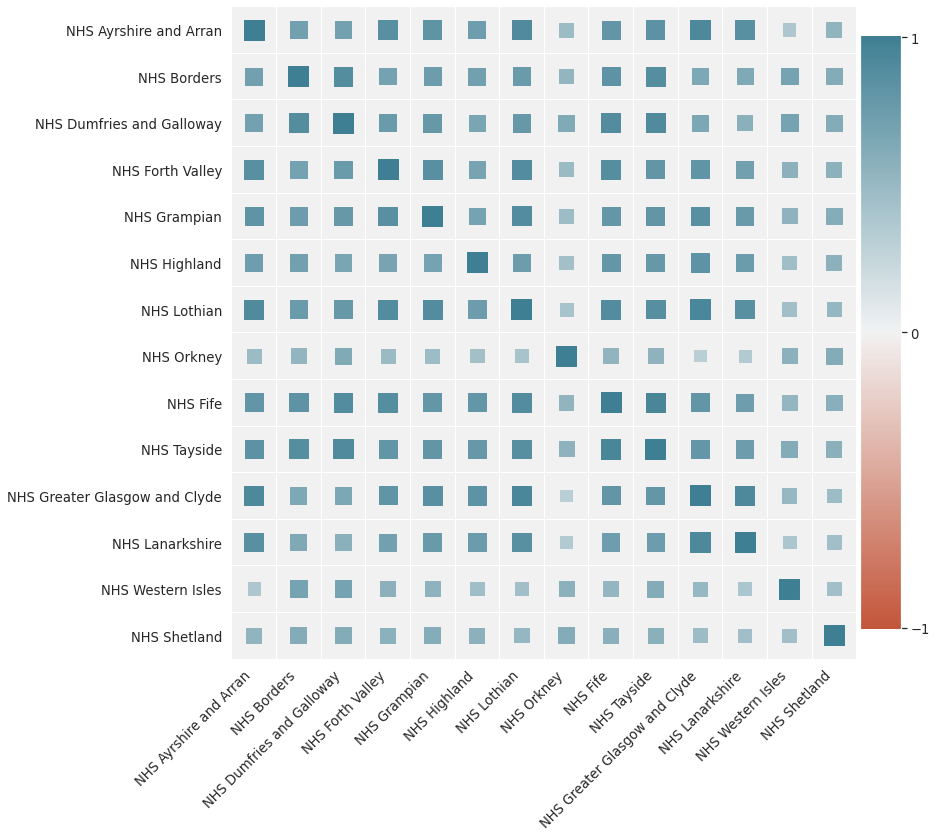

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Correlation matrix of " + col1 + " and " + col2)
corrplot(df_correlation_matrix_with_timelag, size_scale=400)

# Extract the best improvement

In [31]:
temp_df = getTimeSeries(df, max_improvement_HBName1, max_improvement_HBName2, "DailyPositive", "DailyPositive", "hamming")

In [32]:
corr, x_val, lag, dates = getCorrelation(temp_df)

In [33]:
summarise(max_improvement_HBName1, max_improvement_HBName2, lag, corr)

NHS Dumfries and Galloway is behind NHS Grampian by -22 days
Correlation: 78.73%


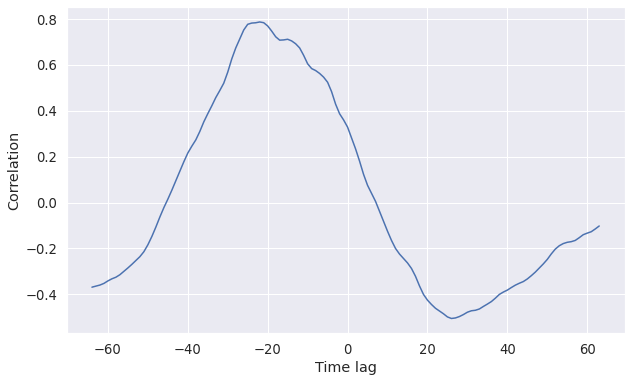

In [34]:
plotTimeLag(x_val, corr)

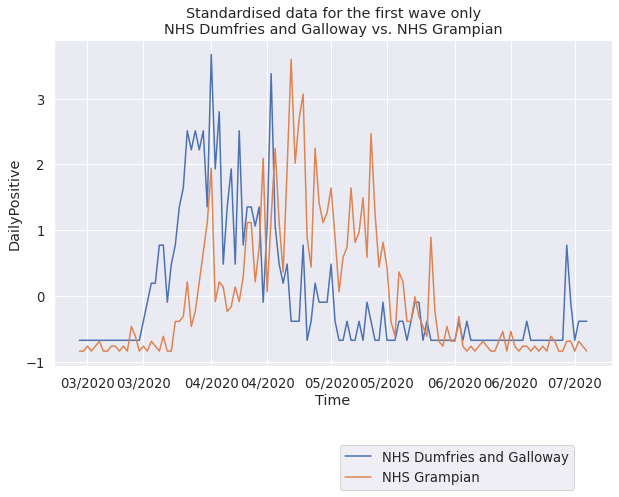

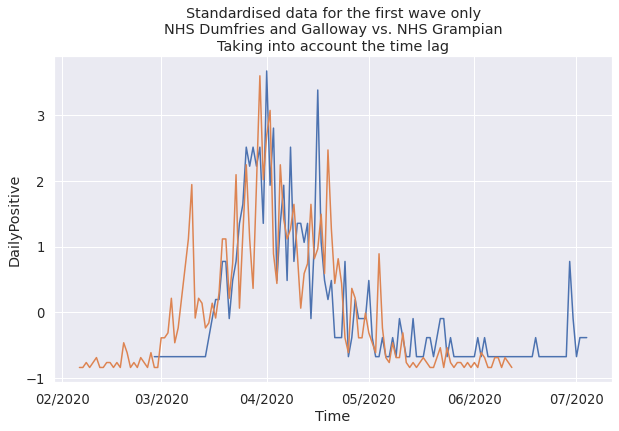

In [35]:
plotWithoutAndWithTimeLag(df,
                          lag,
                          [max_improvement_HBName1, max_improvement_HBName2],
                          ["DailyPositive", "DailyPositive"])

# Extract the largest lag

In [36]:
temp_df = getTimeSeries(df, max_lag_HBName1, max_lag_HBName2, "DailyPositive", "DailyPositive", "hamming")

In [37]:
corr, x_val, lag, dates = getCorrelation(temp_df)

In [38]:
summarise(max_lag_HBName1, max_lag_HBName2, lag, corr)

NHS Grampian is ahead of NHS Tayside by 14 days
Correlation: 80.43%


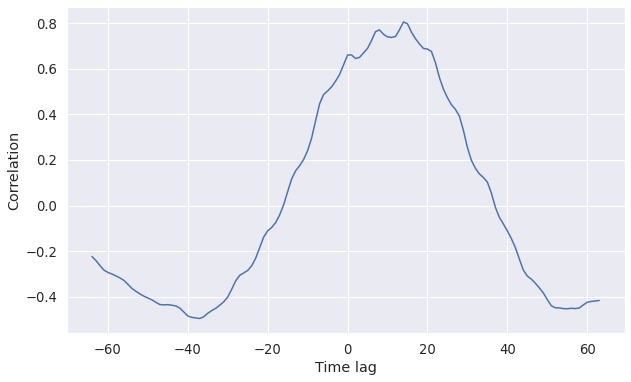

In [39]:
plotTimeLag(x_val, corr)

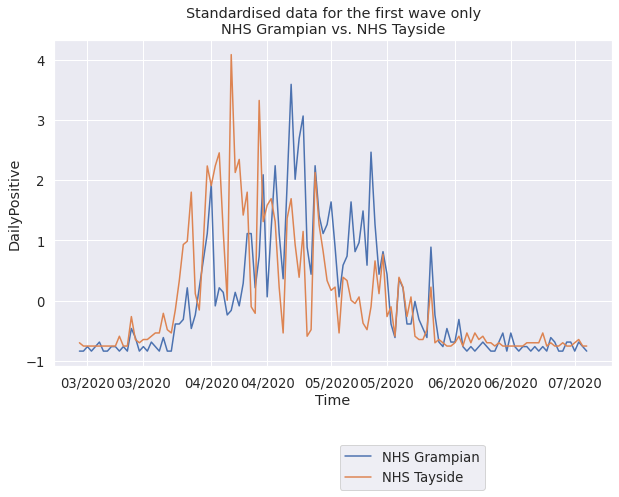

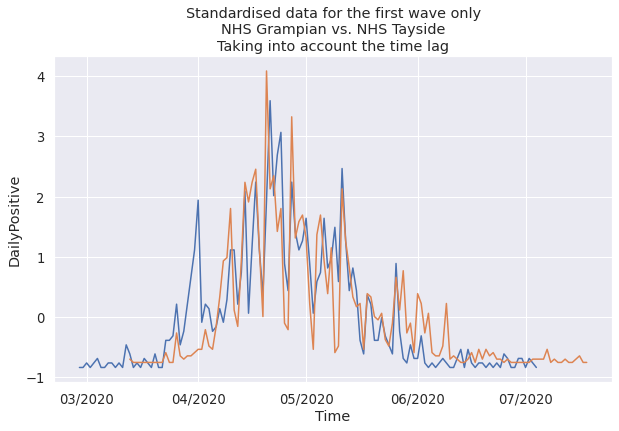

In [40]:
plotWithoutAndWithTimeLag(df,
                          lag,
                          [max_lag_HBName1, max_lag_HBName2],
                          ["DailyPositive", "DailyPositive"])

In [41]:
time_series = []

for HBName in df["HBName"].unique():
    test = df["HBName"] == HBName
    X = df[test]["DailyPositive"].tolist()
    
    while len(X) < 128:
        X.append(0)
        
    X = TimeSeriesScalerMeanVariance().fit_transform([X])[0]

    time_series.append(X)

time_series = np.array(time_series)
time_series.shape = [time_series.shape[0], time_series.shape[1]]

In [42]:
seed=0
ks = KShape(n_clusters=4, verbose=False, random_state=seed)
y_pred = ks.fit_predict(time_series)

In [43]:
print(y_pred)

[2 2 3 3 2 1 2 3 2 2 2 2 0 3]


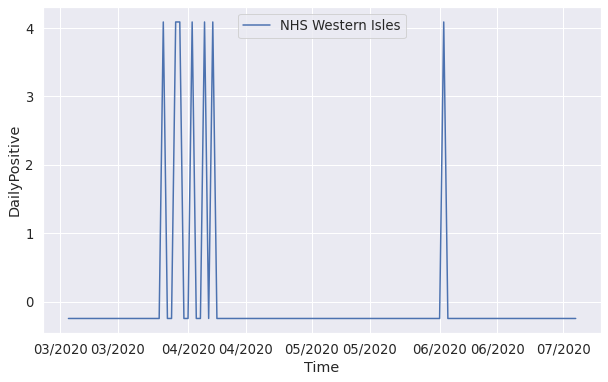

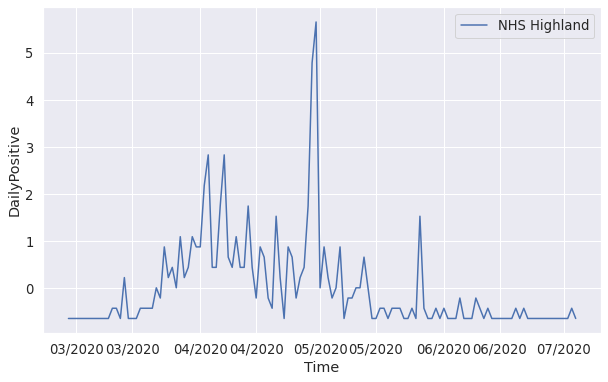

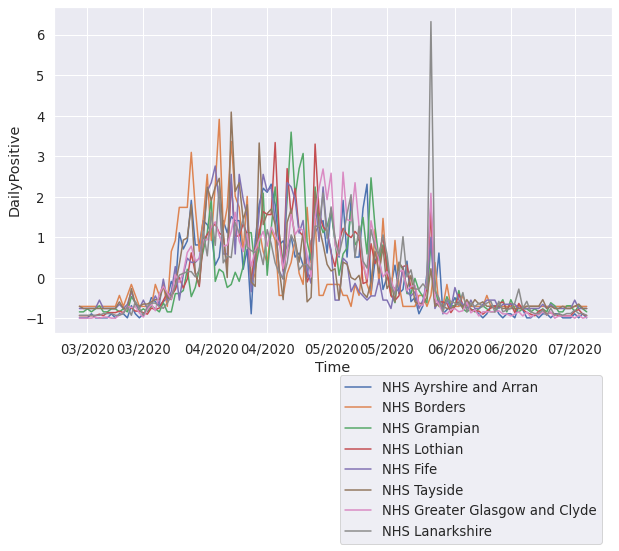

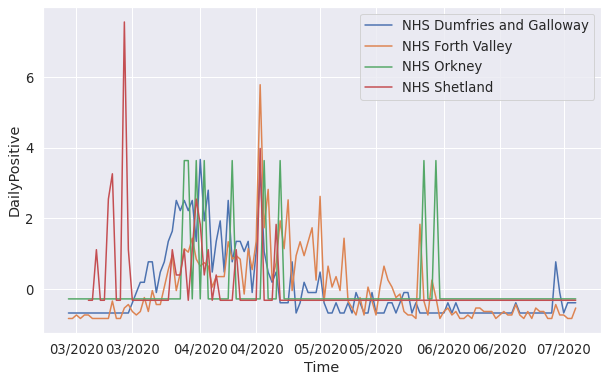

In [44]:
plotClusters(y_pred, df)

At a glance it looks good, but the matter with k-mean is what is `k`? I am not convince the last two clusters are that dissimilar, let's try 3.

In [45]:
seed=0
ks = KShape(n_clusters=3, verbose=False, random_state=seed)
y_pred = ks.fit_predict(time_series)

In [46]:
print(y_pred)

[2 2 2 2 2 1 2 0 2 2 2 2 0 0]


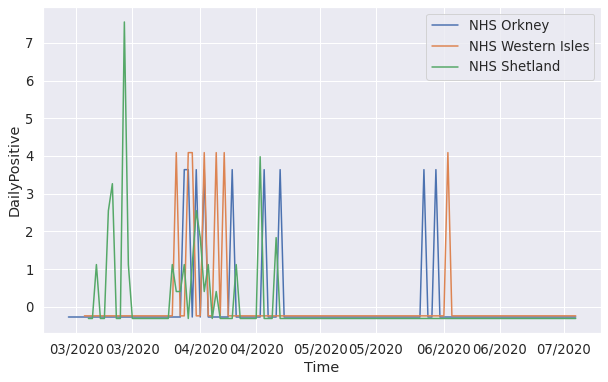

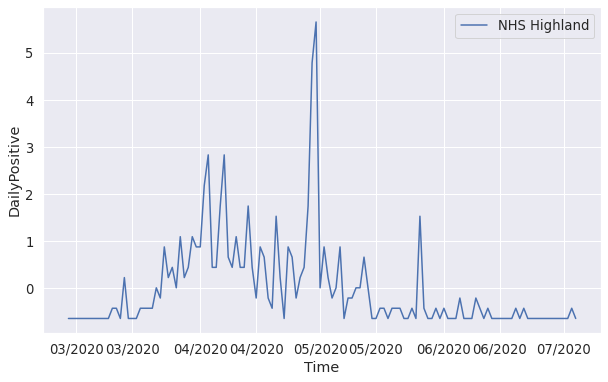

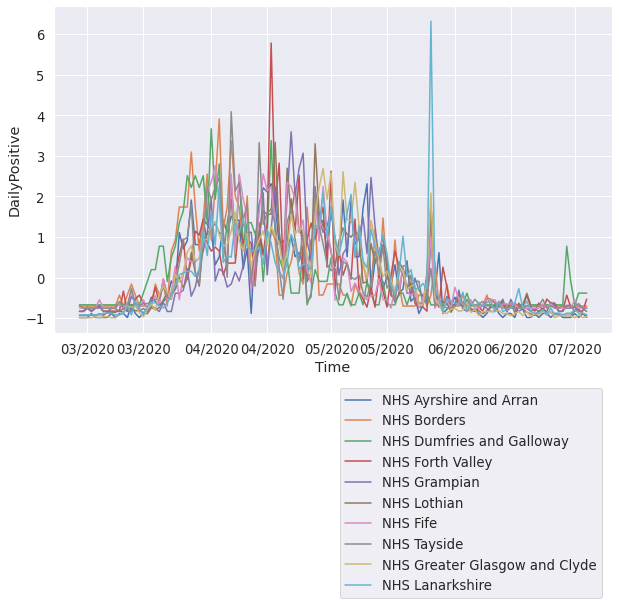

In [47]:
plotClusters(y_pred, df)

# Exploit the correlation matrix to do the clustering

In [48]:
def findSimilarHB(i, HBName, cluster_id, threshold, df_correlation_matrix, cluster_set):

    cluster_members = []
    
    # Process every row
    for index, row in df_correlation_matrix_with_timelag.iterrows():
        
        # This is the right row
        if index == HBName:

            # Process every HB
            for j, HBName2 in enumerate(row):
                
                # The current HB is not in a cluster
                if cluster_set[j] == -1:

                    # Their correlation is higher than or equal to the threshold
                    if row[j] >= threshold:
                        cluster_members.append(j)
    
    return cluster_members
        
        
def cluster_correlation_matrix(threshold):
    
    global cluster_set
    # Create the cluster IDs
    cluster_set = -1 * np.ones(len(df_correlation_matrix_with_timelag.columns)).astype(np.int8)
    
    # Process every cluster
    for i, HBName in enumerate(df_correlation_matrix_with_timelag.columns):

        # The current HB is not in a cluster
        if cluster_set[i] == -1:
            
            # Create a new cluster
            cluster_id = cluster_set.max() + 1
            
            # Add the current HB to the new cluster
            cluster_set[i] = cluster_id
            
        # Re-use the same cluster ID as current HB's
        else:
            cluster_id = cluster_set[i]
            
        # Find similar HBs
        similar_HB = findSimilarHB(i, HBName, cluster_id, threshold, df_correlation_matrix_with_timelag, cluster_set)
            
        # Add them to the cluster
        for j in similar_HB:
            cluster_set[j] = cluster_id


    plotClusters(cluster_set, df)
    plt.show()
    
    return cluster_set

In [49]:
interact_manual(cluster_correlation_matrix, threshold=widgets.FloatSlider(description='Threshold:', value=0.7, min=0.0, max=1.0, step=1e-2));

interactive(children=(FloatSlider(value=0.7, description='Threshold:', max=1.0, step=0.01), Button(description…

Number of clusters: 4


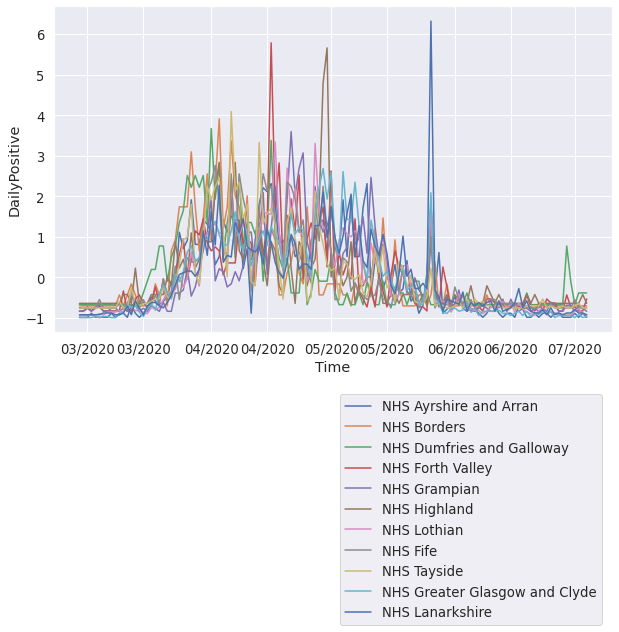

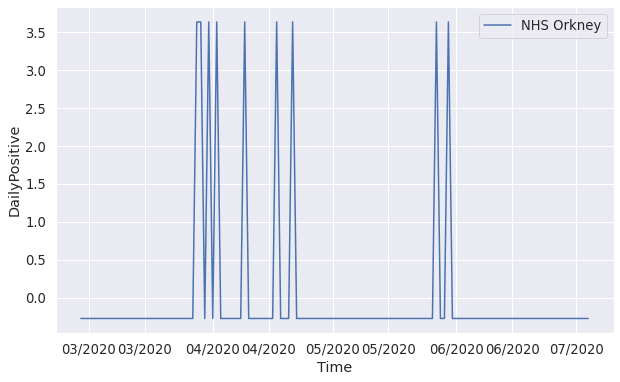

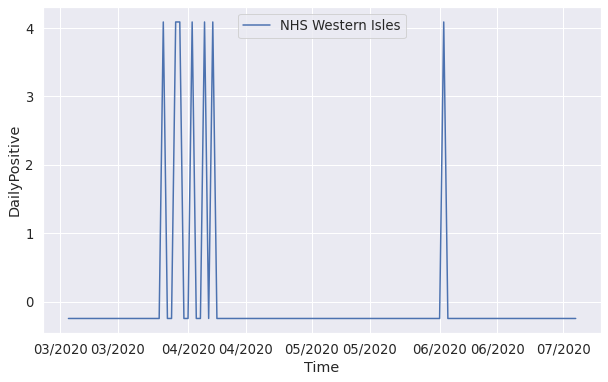

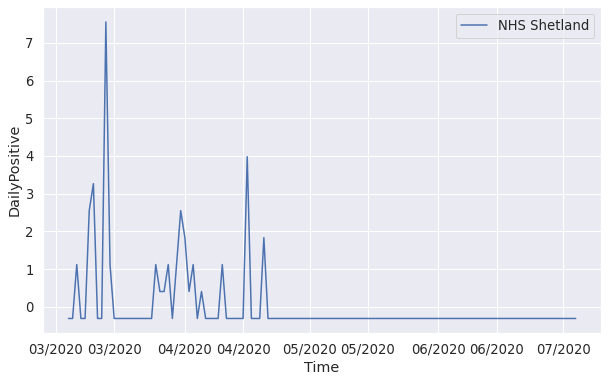

In [50]:
print("Number of clusters:", np.max(cluster_set) + 1)
plotClusters(cluster_set, df)